In [147]:
import numpy as np
import pyaudio
import wave
import matplotlib.pyplot as plt
import struct
from scipy.io import wavfile
import os
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn import svm
import sklearn
import pandas as pd
from scipy.fftpack import fft,fftfreq
from scipy import signal
import math
from scipy.signal import butter, lfilter, freqz

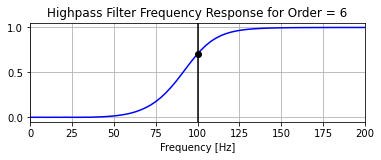

In [182]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='hp', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Filter requirements.
order = 6
fs = 48000    # sample rate, Hz
cutoff = 100  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_highpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, cutoff * 2)
plt.title(f"Highpass Filter Frequency Response for Order = {order}")
plt.xlabel('Frequency [Hz]')
plt.grid()
plt.show()

In [183]:
def get_data(rel_dir):
    width = 1000
    trim_value = 3750_00
    x = []
    y = []
    
    for item in os.listdir(rel_dir):
        if item[0:7] == "lid_off" or item[0:15] == "testing_lid_off":
            y.append(0)
            samplerate, data = wavfile.read(f'{rel_dir}/{item}')
            # trim first 60k samples (shortly after clap)
            data = data[60000:]
            # mean center and scale data
            data = (data - data.mean()) / data.std()
            
            # filter using HPF
            data = butter_highpass_filter(data, cutoff, fs, order);
            data = np.abs(data)

            # filter using HPF
            data = butter_highpass_filter(data, cutoff, fs, order);
            
            # compresses data into bins to reduce dimentionality, works great after filter
            data = data[:(data.size // width) * width].reshape(-1, width).mean(axis=1)

            # looks at the data for the first non-zero value (first peak in wave)
            first_peak = -1
            for i in range(data.size):
                if( data[i] != 0 and first_peak == -1):
                    first_peak = i
            #trim from first peak onwards to end (sound runs long anways)
            data = data[first_peak:]

            # trims from end to have normalized size, scaled by width to accomidate different binning
            data = data[:int(trim_value/width)]
            x.append(data)
            #plt.plot(data, alpha=0.3)
            #plt.axvline(x=first_peak, color="r")
        elif item[0:7] == "lid_on_" or item[0:15] == "testing_lid_on_":
            y.append(1)
            samplerate, data = wavfile.read(f'{rel_dir}/{item}')
            # trim first 60k samples (shortly after clap)
            data = data[60000:]
            # mean center and scale data
            data = (data - data.mean()) / data.std()
            
            # filter using HPF
            data = butter_highpass_filter(data, cutoff, fs, order);
            data = np.abs(data)

            # compresses data into bins to reduce dimentionality, works great after filter
            data = data[:(data.size // width) * width].reshape(-1, width).mean(axis=1)

            # looks at the data for the first non-zero value (first peak in wave)
            first_peak = -1
            for i in range(data.size):
                if( data[i] != 0 and first_peak == -1):
                    first_peak = i
            #trim from first peak onwards to end (sound runs long anways)
            data = data[first_peak:]

            # trims from end to have normalized size, scaled by width to accomidate different binning
            data = data[:int(trim_value/width)]
            x.append(data)
            #plt.plot(data, alpha=0.3)
            #plt.axvline(x=first_peak, color="r")
    plt.show()
    x = np.array(x)
    y = np.array(y)
    return x, y

In [ ]:
x, y = get_data("./training")

nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(20,), random_state=1) #hidden_layer_sizes=(?,)
nn.fit(x,y);

xt, yt = get_data("./testing")


pred =  nn.predict(xt)

print(pd.crosstab(yt, pred))

In [185]:
def get_data_by_state(lid_status, rel_dir): # lid_status = "lid_off" for off, or "lid_on_" for on data
    width = 1000
    trim_value = 3750_00
    x = []
    if lid_status == "lid_off":
        y = np.zeros(10)
    else:
        y = np.ones(10)
    
    for item in os.listdir(rel_dir):
        if item[0:10] == lid_status:
            samplerate, data = wavfile.read(f'{rel_dir}/{item}')
            # trim first 60k samples (shortly after clap)
            data = data[60000:]
            
            
            # mean center and scale data
            data = (data - data.mean()) / data.std()
            
            # filter using HPF
            data = butter_highpass_filter(data, cutoff, fs, order);
            data = np.abs(data)

            # compresses data into bins to reduce dimentionality, works great after filter
            data = data[:(data.size // width) * width].reshape(-1, width).mean(axis=1)

            # looks at the data for the first non-zero value (first peak in wave)
            first_peak = -1
            for i in range(data.size):
                if( data[i] != 0 and first_peak == -1):
                    first_peak = i
            #trim from first peak onwards to end (sound runs long anways)
            data = data[first_peak:]

            # trims from end to have normalized size, scaled by width to accomidate different binning
            data = data[:int(trim_value/width)]
            x.append(data)
            plt.plot(data, alpha=0.3)
            #plt.axvline(x=first_peak, color="r")
    plt.xlabel("Sample Number")
    plt.ylabel("Peak Magnitude")
    plt.title(f"{lid_status} Plot")
    plt.show()
    x = np.array(x)
    return x, y

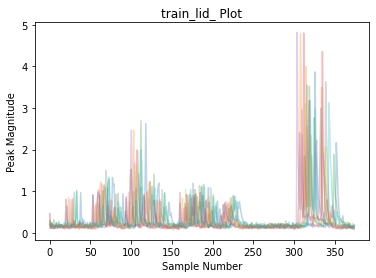

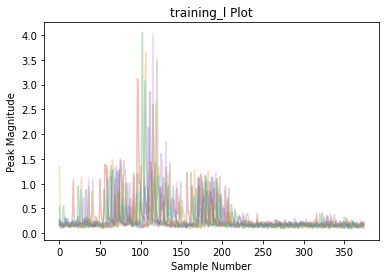

In [186]:
x1, y1 = get_data_by_state("train_lid_", "./training")
x2, y2 = get_data_by_state("training_l", "./training")

In [25]:
def get_audio_data(rel_dir):
    width = 1000
    trim_value = 3750_00
    
    # data from audio files
    x = []
    # corresponding audio file class
    y = []
    # unique classes seen by the algorithm, for creating new classes dynamically
    classes = [];
    
    for item in os.listdir(rel_dir):
        if item[0:7] == "lid_off" or item[0:15] == "testing_lid_off":
            y.append(0)
            samplerate, data = wavfile.read(f'{rel_dir}/{item}')
            # trim first 60k samples (shortly after clap)
            data = data[60000:]
            # mean center and scale data
            data = (data - data.mean()) / data.std()
            
            # filter using HPF
            data = butter_highpass_filter(data, cutoff, fs, order);
            data = np.abs(data)

            # filter using HPF
            data = butter_highpass_filter(data, cutoff, fs, order);
            
            # compresses data into bins to reduce dimentionality, works great after filter
            data = data[:(data.size // width) * width].reshape(-1, width).mean(axis=1)

            # looks at the data for the first non-zero value (first peak in wave)
            first_peak = -1
            for i in range(data.size):
                if( data[i] != 0 and first_peak == -1):
                    first_peak = i
            #trim from first peak onwards to end (sound runs long anways)
            data = data[first_peak:]

            # trims from end to have normalized size, scaled by width to accomidate different binning
            data = data[:int(trim_value/width)]
            x.append(data)
            #plt.plot(data, alpha=0.3)
            #plt.axvline(x=first_peak, color="r")
        elif item[0:7] == "lid_on_" or item[0:15] == "testing_lid_on_":
            y.append(1)
            samplerate, data = wavfile.read(f'{rel_dir}/{item}')
            # trim first 60k samples (shortly after clap)
            data = data[60000:]
            # mean center and scale data
            data = (data - data.mean()) / data.std()
            
            # filter using HPF
            data = butter_highpass_filter(data, cutoff, fs, order);
            data = np.abs(data)

            # compresses data into bins to reduce dimentionality, works great after filter
            data = data[:(data.size // width) * width].reshape(-1, width).mean(axis=1)

            # looks at the data for the first non-zero value (first peak in wave)
            first_peak = -1
            for i in range(data.size):
                if( data[i] != 0 and first_peak == -1):
                    first_peak = i
            #trim from first peak onwards to end (sound runs long anways)
            data = data[first_peak:]

            # trims from end to have normalized size, scaled by width to accomidate different binning
            data = data[:int(trim_value/width)]
            x.append(data)
            #plt.plot(data, alpha=0.3)
            #plt.axvline(x=first_peak, color="r")
    plt.show()
    x = np.array(x)
    y = np.array(y)
    return x, y

In [161]:
def get_audio_data(rel_dir):
    width = 1000
    trim_value = 3750_00
    
    # data from audio files
    x = []
    # corresponding audio file class
    y = []
    # unique classes seen by the algorithm, for creating new classes dynamically
    classes = {};
    
    for item in os.listdir(rel_dir):
        # unqique identifier for file name
        identifier = item[0:12]
        
        # IF statements used to determine if class has been seen before
        if identifier in classes.keys():
            # assign class key to the list of labels
            y.append(classes[identifier])
            
        else:
            # checks if any classes have been added yet
            if( classes):
                # add class file name identifier to the classes, assign index one higher than maximum value present
                classes[identifier] = max(classes.values()) + 1
            else:
                classes[identifier] = 0
            # append new class to list of labels
            y.append(classes[identifier])
        
        
        samplerate, data = wavfile.read(f'{rel_dir}/{item}')
        
        #### ALL CODE BELOW IS DEDICATED TO FEATURE ENGINEERING
        
        # trim first 60k samples (shortly after clap)
        data = data[60000:]
        
        
        # mean center and scale data
        data = (data - data.mean()) / data.std()

        # filter using HPF
        data = butter_highpass_filter(data, cutoff, fs, order);
        data = np.abs(data)

        # compresses data into bins to reduce dimentionality, works great after filter
        data = data[:(data.size // width) * width].reshape(-1, width).mean(axis=1)

        # looks at the data for the first non-zero value (first peak in wave)
        first_peak = -1
        for i in range(data.size):
            if( data[i] != 0 and first_peak == -1):
                first_peak = i
        #trim from first peak onwards to end (sound runs long anways)
        data = data[first_peak:]

        # trims from end to have normalized size, scaled by width to accomidate different binning
        data = data[:int(trim_value/width)]
        x.append(data)
            
        
            
    x = np.array(x)
    y = np.array(y)
    return x, y

In [162]:
classes = {}
print("test" in classes.keys())
#print(max(classes.values()))
#print(classes["test"])
print( bool(classes))

False
False


In [163]:
x, y = get_audio_data("./training")

#nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(20,), random_state=1) #20
nn = linear_model.LogisticRegression(solver = "liblinear" )
#nn = svm.NuSVC()

nn.fit(x,y);

xt, yt = get_audio_data("./testing")


pred =  nn.predict(xt)

print(pd.crosstab(yt, pred))
error_percentage(pred, y)


col_0  0   1  2  3  4   5
row_0                    
0      1   0  0  0  4   0
1      0  10  0  0  0   0
2      0   0  9  0  1   0
3      0   1  0  8  1   0
4      0   0  0  0  5   0
5      0   0  0  0  0  10


86.0

In [126]:
def error_percentage(pred, y):
    
    #print(pred)
    #print(y)
    # the number of errors is the number of differences between the model's labels and the correct labels
    errors = 0
    for i in range(pred.size):
        # pred is the predicted array labels, while y is the actual
        if pred[i] != y[i]:
            errors = errors + 1
            
    # then the percentage of errors is the number of errors divided by the total number of image samples times 100 for percentage.
    return 100 - errors / pred.size * 100